##**BASES DE DADOS**

In [2]:
#baixando as bases de dados
covid_url = '/content/drive/MyDrive/Bootcamp/HIST_PAINEL_COVIDBR_21jan2021.csv' #dados oficiais covid
srag_url = '/content/drive/MyDrive/Bootcamp/INFLUD-18-01-2021.csv' #dados oficiais srag
casos_cwb_url = '/content/drive/MyDrive/Bootcamp/2021-01-15_Casos_Covid_19_-_Base_de_Dados.csv' #dados da prefeitura de cwb - casos
leitos_covid_cwb_url = '/content/drive/MyDrive/Bootcamp/2021-01-21_Censo_Covid19_-_Base_de_Dados.csv' #dados de ocupaçao hospitalar cwb
licitacao_url = '/content/drive/MyDrive/Bootcamp/2021-01-01_Licitacoes_Contratacoes_Covid_Dados_Basicos_-_Base_de_Dados.csv' #licitações covid cwb
doacoes_url = '/content/drive/MyDrive/Bootcamp/2021-01-21_Doacoes_Bens_Servicos_Covid_19_-_Base_de_Dados.csv' #doações covid cwb

## **BIBLIOTECAS**

In [3]:
#!pip install pmdarima

In [4]:
#!pip install sktime

In [5]:
#importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
### Verificando autocorrelações
from pandas.plotting import autocorrelation_plot
#decomposição
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime as dt
from sktime.forecasting.all import *



In [6]:
#melhorando a aparência do gráfico
sns.set_palette('Dark2') #cores
sns.set_style('darkgrid') #estilo das linhas de grade

## **FUNÇÕES**

In [7]:
#criando uma função de plot comparativo - fonte cursos alura
def plot_comparacao(x, y1, y2,y3, dataset,titulo):
  plt.figure(figsize=(12,16))
  ax = plt.subplot(3,1,1) #3 linhas, um gráfico por linha
  ax.set_title(titulo, fontsize=18, loc='left')
  sns.lineplot(x=x, y=y1, data = dataset)
  plota_datas()
  plt.subplot(3,1,2)
  sns.lineplot(x=x, y=y2, data = dataset)
  plota_datas()
  plt.subplot(3,1,3)
  sns.lineplot(x=x, y=y3, data = dataset)
  plota_datas()
  ax=ax

In [8]:
#criando uma função para gerar este gráfico
def plotar(titulo, labelx, labely, x, y, dataset):
  sns.set_palette('Dark2') #cores
  sns.set_style('darkgrid') #estilo das linhas de grade
  #atribuir o gráfico a uma variável - tira as informações do objeto da visualização além de facilitar a customização
  ax = sns.lineplot(x=x, y=y, data = dataset) #define o tipo do gráfico e das variáveis
  ax.figure.set_size_inches(12,6) #configura o tamanho
  ax.set_title(titulo,loc='left', fontsize=18) #configura o título
  ax.set_xlabel(labelx, fontsize=14) #configura o rótulo do eixo X
  ax.set_ylabel(labely, fontsize=14) # configura o rótulo do eixo Y
  ax=ax

In [9]:
def testa_p_value(p_valor):
  if p_valor > 0.05:
    print('A hipótese nula não pode ser rejeitada')
  else:
    print('Podemos rejeitar a hipótese nula')
  print(f'o p_value é de {p_valor}')

In [10]:
def plota_datas():
  plt.axvline(dt.datetime(2020, 6, 13), color='orange')
  plt.axvline(dt.datetime(2020, 8, 17), color='yellow')
  plt.axvline(dt.datetime(2020, 9, 7), color='orange')
  plt.axvline(dt.datetime(2020, 9, 27), color='yellow')
  plt.axvline(dt.datetime(2020, 11, 27), color='orange')

# **BOOTCAMP ALURA - MÓDULO 4 - SÉRIES TEMPORAIS**
## **Evolução da COVID em Curitiba-PR**



Planos: 
* Analisar as bases uma contra a outra, 
* Fazer um perfil dos infectados em Curitiba, 
* Verificar se a base municipal está de acordo com a base federal
* Fazer a série temporal da evolução de casos de covid, 
* Usar a média móvel de 7 e 14 dias pois é o tempo de incubação(?), 


A COVID 19 foi o assunto de 2020. Em curitiba, o esforço da quarentena começou em 16 de março 2020, a casa de muitos (inclusive a minha) virou escritório, Os shows foram substituídos por lives nas redes sociais, as reuniões de trabalho migraram para aplicativos como o Zoom, ou o Teams, e a cada dia, mais pessoas sofreram a dor de perder um amigo ou parente para o vírus. 

Esta análise pretende visualizar a evolução da pandemia na cidade de Curitiba, à luz de sua infraestrutura e esforços do governo municipal. Aqui, os esforços de vacinação iniciaram em 20 de janeiro de 2021, portanto não temos como medir seus impactos. Vamos, no entanto, fazer a projeção da epidemia, caso a vacina não tivesse disponibilizada, tentando prever se nosso sistema de saúde local corre o risco de colapsar. 

Quero também visualizar os efeitos das ações municipais, principalmente o sistema de bandeiras causou algum impacto no aumento de casos na cidade.

Enfim, será que poderei comemorar meu aniversário de 40 anos com meus amigos? 

Para começarmos a nossa análise, e para entendermos um pouco mais o sistema adotado na cidade, seguem alguns dados. Na primeira imagem, constam os principais marcos da pandemia em Curitiba em 2020.

No quadro seguinte, as datas de abertura e fechamento dos comércios em Curitiba, e as ações administrativas. O resumo está no terceiro quadro (sugerimos o zoom para melhor visualização).

Logo após, disponibilizamos material oficial da prefeitura, explicando o funcionamento do sistema de bandeiras, e o que abre e fecha em cada um dos casos

<img src='https://github.com/ClarisseAlvarenga/bootcamp_datascience_alura/blob/main/SEMANA04/covid%20casos%20e%20bandeiras.PNG?raw=true'>

<img src='https://github.com/ClarisseAlvarenga/bootcamp_datascience_alura/blob/main/SEMANA04/covid%20a%C3%A7%C3%B5es%20prefs.PNG?raw=true'>

<img src='https://github.com/ClarisseAlvarenga/bootcamp_datascience_alura/blob/main/SEMANA04/covid%20curitiba.PNG?raw=true' style="width:1500px;height:600px;">

<img src='https://github.com/ClarisseAlvarenga/bootcamp_datascience_alura/blob/main/SEMANA04/criterios%20bandeiras.PNG?raw=true'>

<img src='https://github.com/ClarisseAlvarenga/bootcamp_datascience_alura/blob/main/SEMANA04/bandeiras2.PNG?raw=true' style='center'>

<img src='https://github.com/ClarisseAlvarenga/bootcamp_datascience_alura/blob/main/SEMANA04/bandeiras.PNG?raw=true' style='center'>

Vamos incluir um indicador das bandeiras nos gráficos, onde for possível usando linhas verticais que marcam a data do início da bandeira e a cor da bandeira decretada

## **ANÁLISE EXPLORATÓRIA**
Analisar as bases uma contra a outra

In [11]:
#dados nacionais
covid = pd.read_csv(covid_url,sep=';')
srag = pd.read_csv(srag_url, sep=';', low_memory=False)

In [12]:
#dados municipais
#controle dados covid prefeitura de curitiba
casos_cwb = pd.read_csv(casos_cwb_url, encoding='iso-8859-1', sep=';')
#localização e ocupação leitos cwb
leitos_cwb_21012021 = pd.read_csv(leitos_covid_cwb_url, sep=';', encoding='iso-8859-1', skiprows=1)
#dados básicos licitação de cwb
licitacao_cwb = pd.read_csv(licitacao_url, sep=';', encoding='iso-8859-1')
#doacoes efetuadas para enfrentar a pandemia
doacoes_cwb = pd.read_csv(doacoes_url,sep=';', encoding='iso-8859-1')

In [13]:
covid.head()

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125.0,0,0,0,0,NaN,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125.0,1,1,0,0,NaN,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125.0,1,0,0,0,NaN,NaN,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125.0,1,0,0,0,NaN,NaN,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125.0,2,1,0,0,NaN,NaN,NaN


In [14]:
#buscando os dados do governo para casos novos em Curitiba
covid_cwb = covid[covid['municipio'] == "Curitiba"]
covid_cwb.head()

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
1219920,Sul,PR,Curitiba,41,410690.0,41002.0,2ª RS METROPOLITANA,2020-03-27,13,1933105.0,0,0,0,0,NaN,NaN,1.0
1219921,Sul,PR,Curitiba,41,410690.0,41002.0,2ª RS METROPOLITANA,2020-03-28,13,1933105.0,74,74,0,0,NaN,NaN,1.0
1219922,Sul,PR,Curitiba,41,410690.0,41002.0,2ª RS METROPOLITANA,2020-03-29,14,1933105.0,74,0,0,0,NaN,NaN,1.0
1219923,Sul,PR,Curitiba,41,410690.0,41002.0,2ª RS METROPOLITANA,2020-03-30,14,1933105.0,77,3,0,0,NaN,NaN,1.0
1219924,Sul,PR,Curitiba,41,410690.0,41002.0,2ª RS METROPOLITANA,2020-03-31,14,1933105.0,87,10,0,0,NaN,NaN,1.0


In [15]:
#transformando a coluna em tipo data para permitir a análise de séries temporais
covid_cwb['data'] = pd.to_datetime(covid_cwb['data'], yearfirst=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
data_semanaEpi = covid_cwb[['data', 'semanaEpi']]

In [17]:
data_semanaEpi

,data,semanaEpi
1219920,2020-03-27,13
1219921,2020-03-28,13
1219922,2020-03-29,14
1219923,2020-03-30,14
1219924,2020-03-31,14
...,...,...
1220216,2021-01-17,3
1220217,2021-01-18,3
1220218,2021-01-19,3
1220219,2021-01-20,3


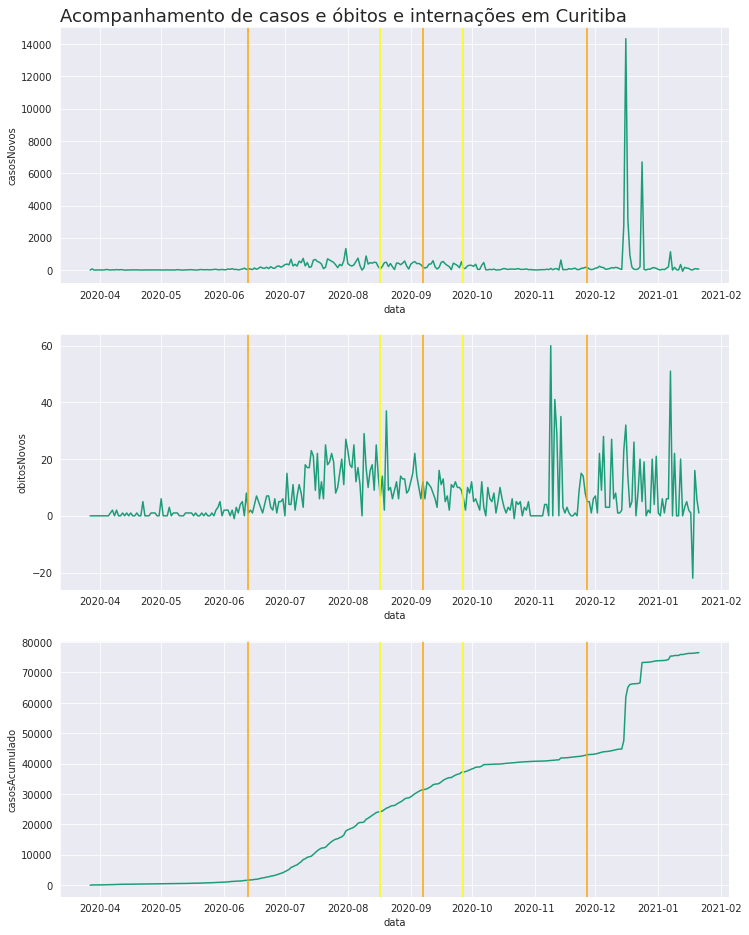

In [18]:
#visualizando os casos novos, os óbitos novos, e os casos em acompanhamento
plot_comparacao('data', 'casosNovos', 'obitosNovos', 'casosAcumulado', covid_cwb, 'Acompanhamento de casos e óbitos e internações em Curitiba')

O valor de mais de 14mil que vemos na base está em desacordo com o [publicado](https://www.curitiba.pr.gov.br/noticias/curitiba-registra-21-mortes-e-1477-casos-de-covid-19/57463) pela prefeitura, portanto vamos verificar os dias anteriores se houve alguma falha nos boletins

In [19]:
#vamos verificar o dia da alta
covid_cwb.loc[covid_cwb['casosNovos'] >10000]

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
1220184,Sul,PR,Curitiba,41,410690.0,41002.0,2ª RS METROPOLITANA,2020-12-16,51,1933105.0,61934,14338,1828,32,NaN,NaN,1.0


In [20]:
covid_cwb.loc[covid_cwb['semanaEpi']== 51]

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
1220181,Sul,PR,Curitiba,41,410690.0,41002.0,2ª RS METROPOLITANA,2020-12-13,51,1933105.0,44782,83,1771,1,NaN,NaN,1.0
1220182,Sul,PR,Curitiba,41,410690.0,41002.0,2ª RS METROPOLITANA,2020-12-14,51,1933105.0,44821,39,1773,2,NaN,NaN,1.0
1220183,Sul,PR,Curitiba,41,410690.0,41002.0,2ª RS METROPOLITANA,2020-12-15,51,1933105.0,47596,2775,1796,23,NaN,NaN,1.0
1220184,Sul,PR,Curitiba,41,410690.0,41002.0,2ª RS METROPOLITANA,2020-12-16,51,1933105.0,61934,14338,1828,32,NaN,NaN,1.0
1220185,Sul,PR,Curitiba,41,410690.0,41002.0,2ª RS METROPOLITANA,2020-12-17,51,1933105.0,65097,3163,1842,14,NaN,NaN,1.0
1220186,Sul,PR,Curitiba,41,410690.0,41002.0,2ª RS METROPOLITANA,2020-12-18,51,1933105.0,66025,928,1845,3,NaN,NaN,1.0
1220187,Sul,PR,Curitiba,41,410690.0,41002.0,2ª RS METROPOLITANA,2020-12-19,51,1933105.0,66213,188,1850,5,NaN,NaN,1.0


Vemos que os casos acumulados mudam drasticamente no período, e que não estão de acordo com o indicado pela prefeitura (que pela divulgação oficial contava com 99470 casos acumulados em 16 de dezembro de 2020, motivo pelo qual vou escolher usar a base do município para meus estudos

In [21]:
casos_cwb.head()

,POSIÇÃO,DATA INCLUSÃO/ NOTIFICAÇÃO,CLASSIFICAÇÃO FINAL,IDADE (anos),SEXO,DATA ÓBITO,ENCERRAMENTO (CASOS CONFIRMADOS OU ÓBITOS)
0,1,11/03/2020,CONFIRMADO,54.0,M,NaN,RECUPERADO
1,2,12/03/2020,CONFIRMADO,43.0,M,NaN,RECUPERADO
2,3,12/03/2020,CONFIRMADO,15.0,M,NaN,RECUPERADO
3,4,12/03/2020,CONFIRMADO,25.0,F,NaN,RECUPERADO
4,5,12/03/2020,CONFIRMADO,58.0,M,NaN,RECUPERADO


In [22]:
casos_cwb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119722 entries, 0 to 119721
Data columns (total 7 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   POSIÇÃO                                     119722 non-null  int64  
 1   DATA INCLUSÃO/ NOTIFICAÇÃO                  119722 non-null  object 
 2   CLASSIFICAÇÃO FINAL                         119722 non-null  object 
 3   IDADE (anos)                                119660 non-null  float64
 4   SEXO                                        119722 non-null  object 
 5   DATA ÓBITO                                  2423 non-null    object 
 6   ENCERRAMENTO (CASOS CONFIRMADOS OU ÓBITOS)  111834 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 6.4+ MB


In [23]:
#transformando a coluna de data em datetime
casos_cwb['DATA'] = pd.to_datetime(casos_cwb['DATA INCLUSÃO/ NOTIFICAÇÃO'],dayfirst=True)

In [24]:
casos_confirmados_cwb = pd.crosstab(index=casos_cwb['DATA INCLUSÃO/ NOTIFICAÇÃO'], columns=casos_cwb['CLASSIFICAÇÃO FINAL']).reset_index()

In [25]:
casos_confirmados_cwb['DATA'] = pd.to_datetime(casos_confirmados_cwb['DATA INCLUSÃO/ NOTIFICAÇÃO'], dayfirst=True)

In [26]:
casos_confirmados = casos_confirmados_cwb.sort_values(by='DATA').set_index('DATA').drop('DATA INCLUSÃO/ NOTIFICAÇÃO', axis=1)

In [27]:
casos_confirmados.head()

CLASSIFICAÇÃO FINAL,CONFIRMADO
DATA,
2020-03-11,1
2020-03-12,4
2020-03-13,4
2020-03-14,1
2020-03-15,3


Podemos ver que os dados da prefeitura estão mais "limpos", sem o outlier de 16 de dezembro visualizado na base oficial

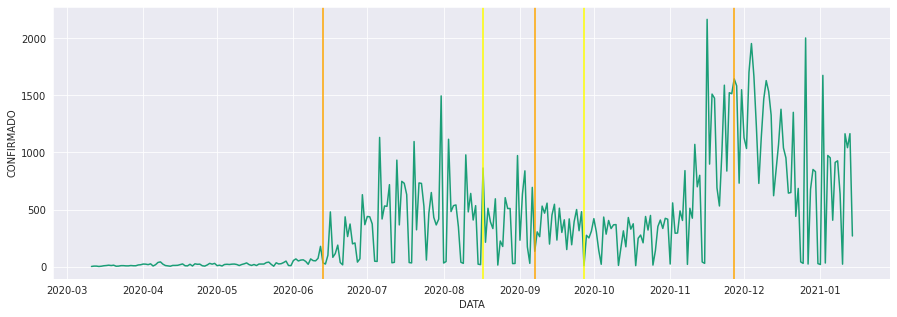

In [28]:
plt.figure(figsize=(15,5))
ax = sns.lineplot(data=casos_confirmados, x=casos_confirmados.index, y='CONFIRMADO')
plota_datas();

### **ESCOLHA E TRATAMENTO DE DADOS**

In [29]:
casos_cwb.isna().sum()

POSIÇÃO                                            0
DATA INCLUSÃO/ NOTIFICAÇÃO                         0
CLASSIFICAÇÃO FINAL                                0
IDADE (anos)                                      62
SEXO                                               0
DATA ÓBITO                                    117299
ENCERRAMENTO (CASOS CONFIRMADOS OU ÓBITOS)      7888
DATA                                               0
dtype: int64

In [30]:
#alterando o nome das colunas para facilitar o trabalho
casos_cwb.columns = ['posicao', 'notificacao','classificacao_final', 'idade', 'genero','data_obito','situacao_final','data']

In [31]:
casos_cwb.classificacao_final.unique()

array(['CONFIRMADO'], dtype=object)

In [32]:
#conferindo os casos sem situação Final
casos_cwb[casos_cwb['situacao_final'].isna()]

,posicao,notificacao,classificacao_final,idade,genero,data_obito,situacao_final,data
8950,8951,08/07/2020,CONFIRMADO,69.0,F,NaN,NaN,2020-07-08
15819,15820,22/07/2020,CONFIRMADO,51.0,F,NaN,NaN,2020-07-22
21996,21997,03/08/2020,CONFIRMADO,74.0,F,NaN,NaN,2020-08-03
22907,22908,05/08/2020,CONFIRMADO,29.0,M,NaN,NaN,2020-08-05
23164,23165,05/08/2020,CONFIRMADO,36.0,F,NaN,NaN,2020-08-05
...,...,...,...,...,...,...,...,...
119716,119717,14/01/2021,CONFIRMADO,28.0,F,NaN,NaN,2021-01-14
119717,119718,14/01/2021,CONFIRMADO,34.0,F,NaN,NaN,2021-01-14
119718,119719,14/01/2021,CONFIRMADO,41.0,M,NaN,NaN,2021-01-14
119719,119720,14/01/2021,CONFIRMADO,67.0,M,NaN,NaN,2021-01-14


Nossa estratégia para suprir os nulos no campo Situação Final, será alterá-lo para ATIVOS, pois é a nomenclatura usada pela Prefeitura em sua comunicação oficial:

<img src='https://github.com/ClarisseAlvarenga/bootcamp_datascience_alura/blob/main/SEMANA04/quadro%20oficial%2014012020.PNG?raw=true'>

In [33]:
casos_cwb['situacao_final'] = casos_cwb['situacao_final'].fillna('ATIVO')

In [34]:
dados = casos_cwb.merge(data_semanaEpi, on='data')

In [35]:
dados

,posicao,notificacao,classificacao_final,idade,genero,data_obito,situacao_final,data,semanaEpi
0,98,27/03/2020,CONFIRMADO,32.0,M,NaN,RECUPERADO,2020-03-27,13
1,99,27/03/2020,CONFIRMADO,58.0,F,NaN,RECUPERADO,2020-03-27,13
2,100,27/03/2020,CONFIRMADO,36.0,M,NaN,RECUPERADO,2020-03-27,13
3,101,27/03/2020,CONFIRMADO,36.0,F,NaN,RECUPERADO,2020-03-27,13
4,102,27/03/2020,CONFIRMADO,46.0,F,NaN,RECUPERADO,2020-03-27,13
...,...,...,...,...,...,...,...,...,...
119620,119718,14/01/2021,CONFIRMADO,34.0,F,NaN,ATIVO,2021-01-14,2
119621,119719,14/01/2021,CONFIRMADO,41.0,M,NaN,ATIVO,2021-01-14,2
119622,119720,14/01/2021,CONFIRMADO,67.0,M,NaN,ATIVO,2021-01-14,2
119623,119721,14/01/2021,CONFIRMADO,47.0,M,NaN,ATIVO,2021-01-14,2


In [36]:
semana_epi_2020 = pd.crosstab(index=dados['semanaEpi'], columns=dados['classificacao_final']).drop([1,2])
semana_epi_2020.head()

classificacao_final,CONFIRMADO
semanaEpi,
13,16
14,121
15,134
16,81
17,103


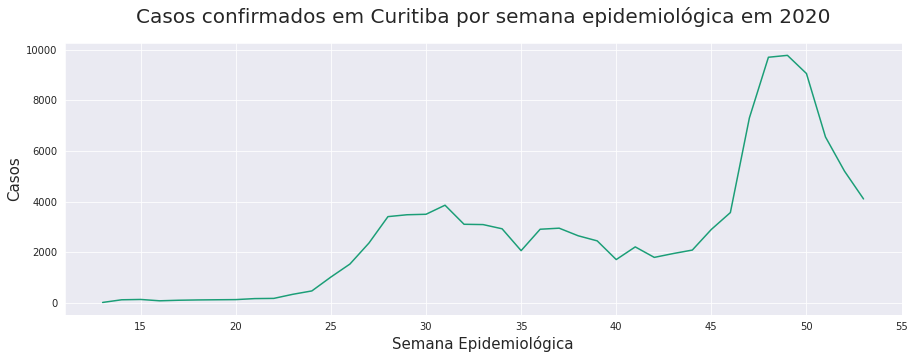

In [37]:
#vamos ver a curva de casos confirmados por semana epidemiológica
plt.figure(figsize=(15,5))
ax = sns.lineplot(data=semana_epi_2020, x=semana_epi_2020.index, y='CONFIRMADO')
ax.set_title('Casos confirmados em Curitiba por semana epidemiológica em 2020', fontsize=20, pad=20)
ax.set_ylabel('Casos', fontsize=15)
ax.set_xlabel('Semana Epidemiológica', fontsize=15);

In [38]:
casos_cwb.head()

,posicao,notificacao,classificacao_final,idade,genero,data_obito,situacao_final,data
0,1,11/03/2020,CONFIRMADO,54.0,M,NaN,RECUPERADO,2020-03-11
1,2,12/03/2020,CONFIRMADO,43.0,M,NaN,RECUPERADO,2020-03-12
2,3,12/03/2020,CONFIRMADO,15.0,M,NaN,RECUPERADO,2020-03-12
3,4,12/03/2020,CONFIRMADO,25.0,F,NaN,RECUPERADO,2020-03-12
4,5,12/03/2020,CONFIRMADO,58.0,M,NaN,RECUPERADO,2020-03-12


In [39]:
casos_cwb['data_obito_dt'] = pd.to_datetime(casos_cwb['data_obito'], dayfirst=True)

In [40]:
obitos_cwb = pd.crosstab(index=casos_cwb['data_obito_dt'], columns=casos_cwb['situacao_final']).reset_index()
obitos_cwb.set_index('data_obito_dt',inplace=True)

In [41]:
obitos_cwb

situacao_final,ÓBITO CONF
data_obito_dt,
2020-04-06,3
2020-04-07,3
2020-04-13,1
2020-04-14,1
2020-04-18,1
...,...
2021-01-09,7
2021-01-10,5
2021-01-11,6


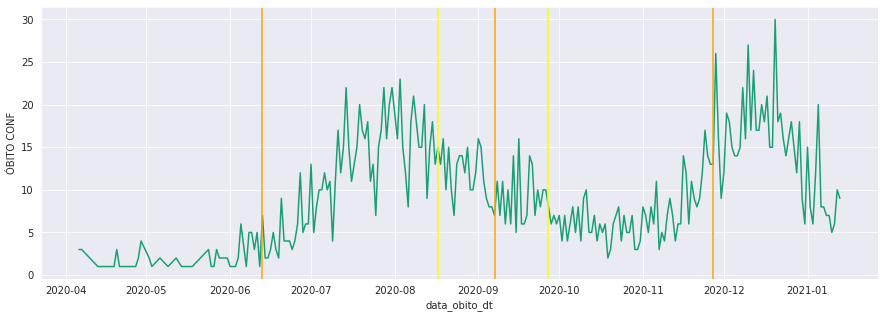

In [42]:
#vemos que a curva de óbitos é bem parecida com a curva de casos confirmados
plt.figure(figsize=(15,5))
ax = sns.lineplot(data=obitos_cwb, x=obitos_cwb.index, y='ÓBITO CONF')
plota_datas();

### **Perfil do Curitibano que contraiu COVID**:
Fazer um perfil dos infectados em Curitiba

In [43]:
#Vendo a proporcao entre gêneros
casos_cwb['genero'].value_counts(normalize=True)*100

F    54.408546
M    45.591454
Name: genero, dtype: float64

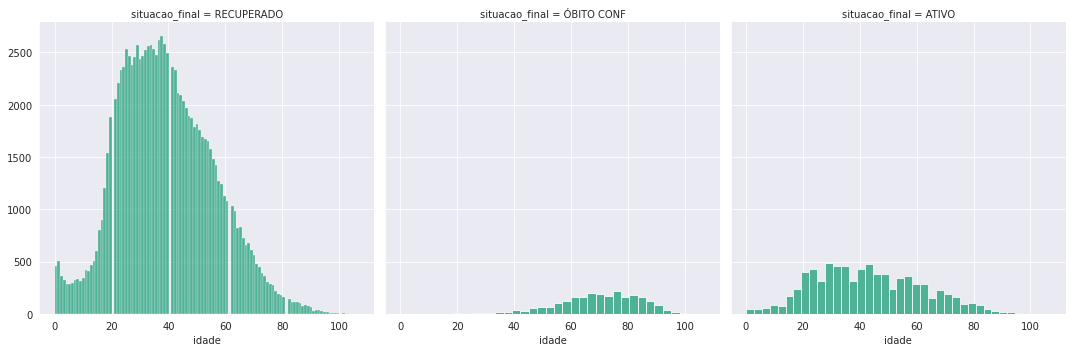

In [44]:
#plotando o histograma da idade por situação
g = sns.FacetGrid(data=casos_cwb, col='situacao_final', height=5, aspect=1)
g.map(sns.histplot,'idade');

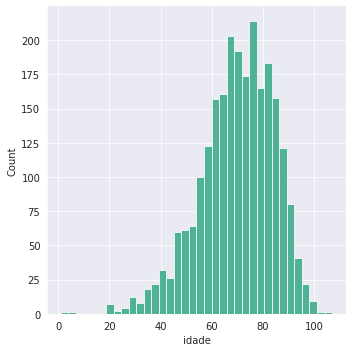

In [45]:
#visualizando a distribuição de casos com óbito confirmado 
sns.displot(data=casos_cwb[casos_cwb['situacao_final'] == 'ÓBITO CONF'], x='idade');


In [46]:
#verificando estatisticamente que as distribuições de idades por óbito e por casos confirmados é diferente
from scipy.stats import ranksums, wilcoxon
obitos = casos_cwb[casos_cwb['situacao_final'] == 'ÓBITO CONF']['idade']
recuperados = casos_cwb[casos_cwb['situacao_final'] == 'RECUPERADO']['idade']


In [47]:
#excluindo as informações nulas
recuperados.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Vemos que há uma diferença grande entre a idade das pessoas que se recuperam da doença e a idade média de quem não sobrevive

In [48]:
print(f'A média de idade de quem se recuperou da doença em Curitiba é de {round(recuperados.mean(),0)}')
print(f'Já a média de idade daqueles que vieram a óbito em Curitiba é de {round(obitos.mean(),0)}')
print(f'A média geral daqueles que contraem a doença é de {round(casos_cwb.idade.mean(),0)} anos')


A média de idade de quem se recuperou da doença em Curitiba é de 39.0
Já a média de idade daqueles que vieram a óbito em Curitiba é de 70.0
A média geral daqueles que contraem a doença é de 40.0 anos


Podemos fazer um teste estatístico para demonstrar que se trata efetivamente de distribuições diferentes. O Ranksums é um teste não paramétrico (escolhido pois nossas distribuições de idade não são simétricas e não se comportam como uma normal (visível graficamente), e trabalha com a hipótese nula de que as duas amostras foram tiradas da mesma distribuição, já a hipótese alternativa é que que uma das amostras tem valores maiores do que a outra.

Vamos usar a significância de 0,05 para analisar nossa hipótese.

In [49]:
stat,p_value = ranksums(obitos, recuperados)
testa_p_value(p_value)

Podemos rejeitar a hipótese nula
o p_value é de 0.0


Portanto, podemos afirmar que há uma diferença clara entre o grupo dos recuperados e o grupo que veio a falecer. Estes são significativamente mais velhos do que aqueles que contraem a doença e se recuperam. Para mostrar ainda melhor esta relação, vamos plotar um boxplot das idades por situação final

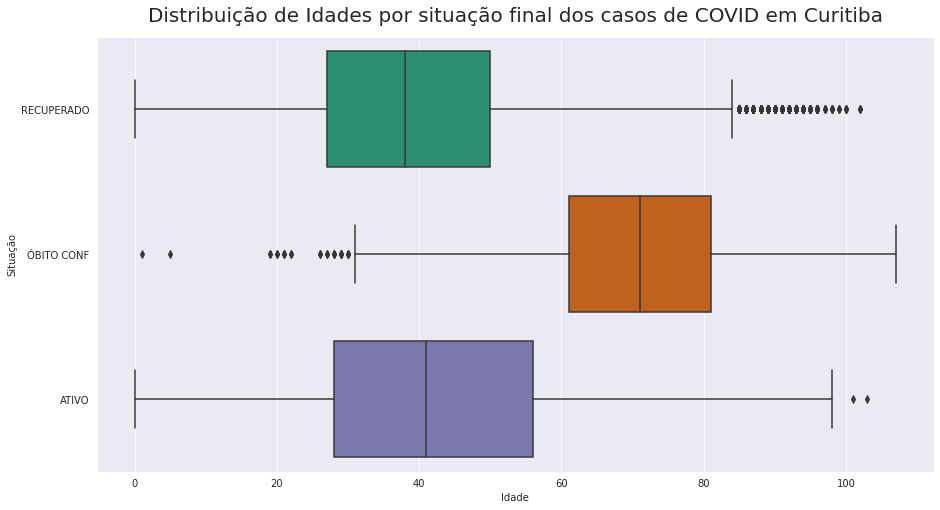

In [50]:
plt.figure(figsize=(15,8))
sns.boxplot(data=casos_cwb, x='idade', y='situacao_final')
plt.title('Distribuição de Idades por situação final dos casos de COVID em Curitiba', fontsize=20, pad=15)
plt.ylabel('Situação')
plt.xlabel('Idade');

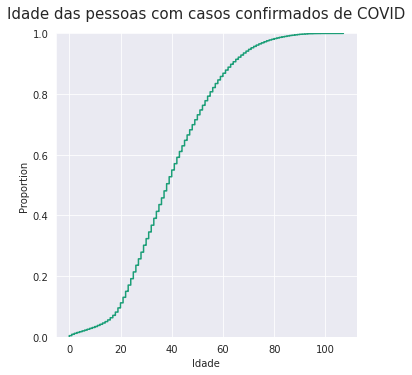

In [51]:
#Vamos ver a distribuição de todos os casos
sns.displot(data=casos_cwb, x='idade',kind='ecdf')
plt.title('Idade das pessoas com casos confirmados de COVID', fontsize=15, pad=15)
plt.xlabel('Idade');

Isto no mostra que, apesar de mais de 80% dos infectados com a doença estarem com menos de 60 anos, apenas 25% daqueles que morrem tem menos do que 60 anos, sendo a média 70 anos de idade. Isto mostra que realmente os idosos são um grupo de risco para o agravamento da doença. Vamos ver o percentual de casos  recuperados e óbitos para a população idosa.

In [52]:
idosos = casos_cwb[casos_cwb['idade'] >= 60 ]
jovens = casos_cwb[casos_cwb['idade'] < 60 ]

In [53]:
idosos['situacao_final'].value_counts(normalize=True)*100

RECUPERADO    79.412111
ÓBITO CONF    11.086239
ATIVO          9.501649
Name: situacao_final, dtype: float64

In [54]:
jovens['situacao_final'].value_counts(normalize=True)*100

RECUPERADO    93.363133
ATIVO          6.110007
ÓBITO CONF     0.526859
Name: situacao_final, dtype: float64

In [55]:
casos_cwb['situacao_final'].value_counts(normalize=True)*100

RECUPERADO    91.387548
ATIVO          6.588597
ÓBITO CONF     2.023855
Name: situacao_final, dtype: float64

Em Curitiba, enquanto a COVID se demonstra letal para 11% das pessoas com mais de 60 anos que contraem a doença, ela é letal para apenas 0,52% das pessoas com menos de 60 anos, representando 2% da população diagnosticada. Vamos ver se há alguma diferença entre gêneros. Já vimos que a proporção de mulheres diagnosticada em Curitiba é maior que a de homens (54% contra 46%):


In [56]:
#vendo a situação por tipo de situação final
pd.crosstab(index=casos_cwb['situacao_final'], columns=casos_cwb['genero'],normalize='columns')*100

genero,F,M
situacao_final,,
ATIVO,6.516833,6.674239
RECUPERADO,91.857413,90.826814
ÓBITO CONF,1.625754,2.498947


No entanto, a taxa de mortalidade demonstra ser menor em mulheres do que em homens nesta população. Uma hipótese é o estereótipo de que mulheres vão mais ao médico quando se sentem mal, e esta diferença pode se explicar simplesmente por uma maior incidência de casos leves diagnosticados em mulheres. Vemos também que não há uma grande diferença de idade entre os casos recuperados e os casos ativos, mas que a idade média das mulheres que vieram a falecer por conta da COVID é maior que a dos homens.

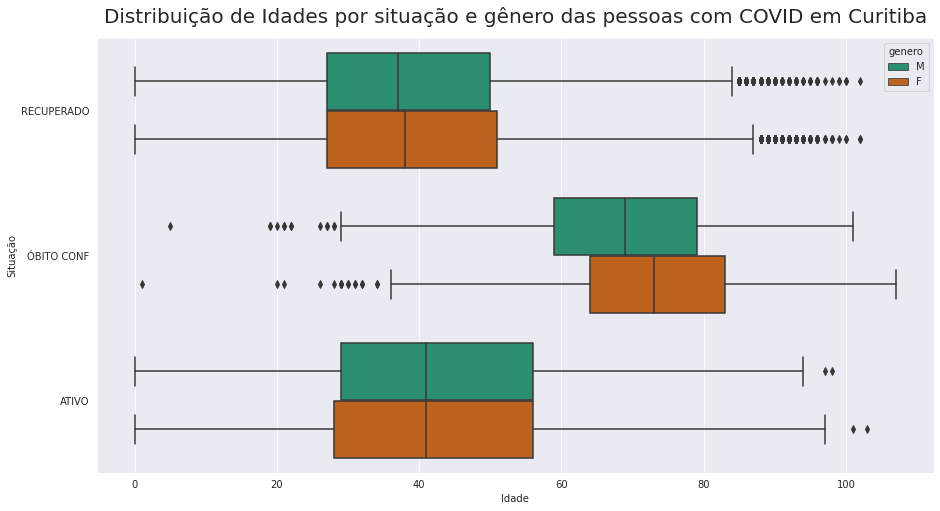

In [57]:
plt.figure(figsize=(15,8))
sns.boxplot(data=casos_cwb, x='idade', y='situacao_final', hue='genero')
plt.title('Distribuição de Idades por situação e gênero das pessoas com COVID em Curitiba', fontsize=20, pad=15)
plt.ylabel('Situação')
plt.xlabel('Idade');

### **ANÁLISE DAS SÉRIES TEMPORAIS** 

A partir de agora vamos trabalhar com as bases de casos confirmados, obitos e casos por semana epidemiológica

In [58]:
casos_confirmados.head()

CLASSIFICAÇÃO FINAL,CONFIRMADO
DATA,
2020-03-11,1
2020-03-12,4
2020-03-13,4
2020-03-14,1
2020-03-15,3


In [59]:
obitos_cwb.head()

situacao_final,ÓBITO CONF
data_obito_dt,
2020-04-06,3
2020-04-07,3
2020-04-13,1
2020-04-14,1
2020-04-18,1


In [60]:
semana_epi_2020.head()

classificacao_final,CONFIRMADO
semanaEpi,
13,16
14,121
15,134
16,81
17,103


#### **Decomposição dos dados de Casos Confirmado**

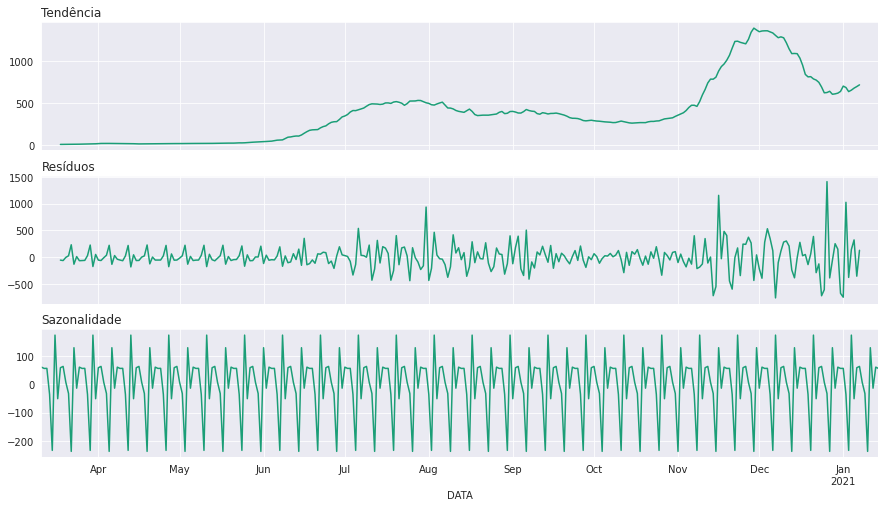

In [61]:
resultado = seasonal_decompose(casos_confirmados[['CONFIRMADO']],period=14) #o número q queremos 
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8), sharex=True)
resultado.trend.plot(ax=ax1)
resultado.resid.plot(ax=ax2)
resultado.seasonal.plot(ax=ax3)
ax1.set_title('Tendência',loc='left')
ax2.set_title('Resíduos',loc='left')
ax3.set_title('Sazonalidade',loc='left');


#### **Decomposição dos dados de óbitos confirmados**

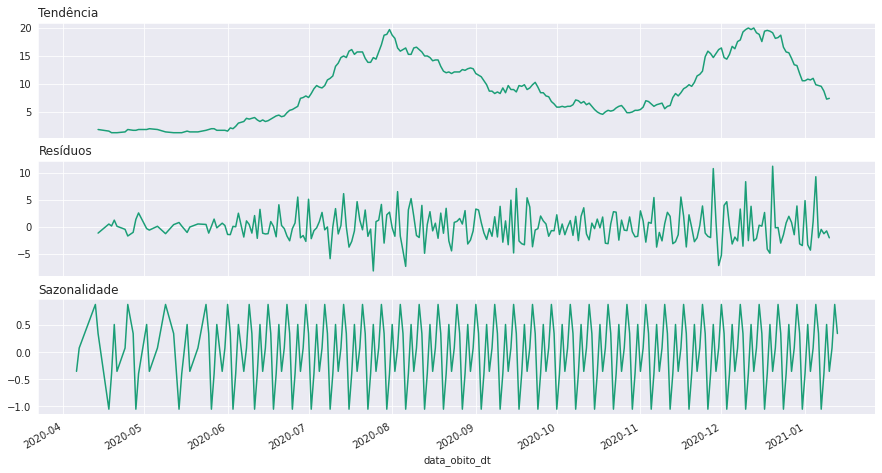

In [62]:
resultado = seasonal_decompose(obitos_cwb[['ÓBITO CONF']],period=7) #o número q queremos 
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8), sharex=True)
resultado.trend.plot(ax=ax1)
resultado.resid.plot(ax=ax2)
resultado.seasonal.plot(ax=ax3)
ax1.set_title('Tendência',loc='left',)
ax2.set_title('Resíduos',loc='left')
ax3.set_title('Sazonalidade',loc='left');

#### **MÉDIA MÓVEL DE CASOS CONFIRMADOS EM CURITIBA**

In [63]:
#fazendo a média móvel de 7 e 14 dias
casos_confirmados['media_movel_7'] = casos_confirmados['CONFIRMADO'].rolling(7).mean()
casos_confirmados['media_movel_14'] = casos_confirmados['CONFIRMADO'].rolling(14).mean()

In [64]:
casos_confirmados

CLASSIFICAÇÃO FINAL,CONFIRMADO,media_movel_7,media_movel_14
DATA,,,
2020-03-11,1,NaN,NaN
2020-03-12,4,NaN,NaN
2020-03-13,4,NaN,NaN
2020-03-14,1,NaN,NaN
2020-03-15,3,NaN,NaN
...,...,...,...
2021-01-10,21,690.000000,638.714286
2021-01-11,1164,717.142857,673.428571
2021-01-12,1042,729.857143,687.071429


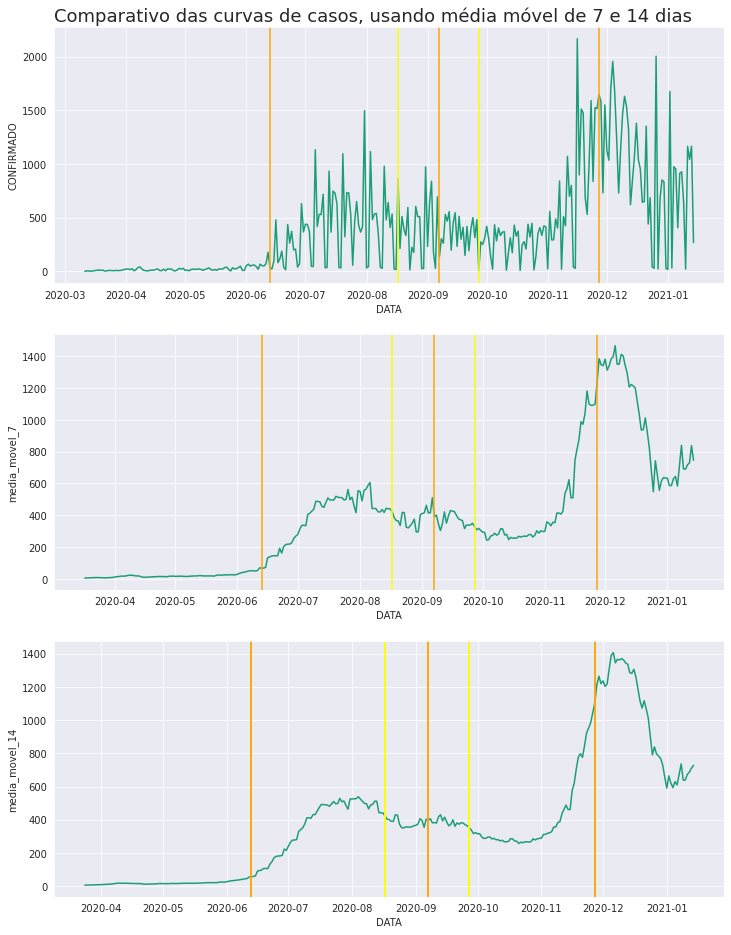

In [65]:
plot_comparacao(casos_confirmados.index, 'CONFIRMADO', 'media_movel_7', 
                'media_movel_14', casos_confirmados, 'Comparativo das curvas de casos, usando média móvel de 7 e 14 dias')
plota_datas()

#### **TESTANDO A ESTACIONARIEDADE DOS DADOS


**

"Uma série temporal é dita estacionária quando ela se desenvolve no tempo aleatoriamente ao redor de uma média constante, refletindo alguma forma de equilíbrio estável. Na prática, a maioria das séries que encontramos apresentam algum tipo de não estacionariedade, por exemplo, tendência."

Visualmente nossa série temporal não é estacionária, mas vamos aplicar o teste ADF para verificar nossa hipótese

[Fonte](http://www.portalaction.com.br/series-temporais/11-estacionariedade#:~:text=Uma%20s%C3%A9rie%20temporal%20%C3%A9%20dita,estacionariedade%2C%20por%20exemplo%2C%20tend%C3%AAncia.)

**Teste Augmented Dickey-Fuller (ADF)**

***Conforme documentação do statsmodels, a função adfuller retorna:***

**adf** *(float)*: o teste estatístico

**pvalue** *(float)*: o p_value baseado em MacKinnon(1994,2010)

**usedlag** *(int)*: O número de *lags* usado.

**nobs** *(int)*: O número de observações usados para a regressão ADF e cálculo dos valores críticos.

**critical values** *(dict)*: Os valores críticos do teste estatístico (significância?) níveis de 1 %, 5 %, e 10 % levels. Baseado em MacKinnon (2010).

**icbest** *(float)*: a o critério de informação maximizada se o autolag(atributo da função) não for *None*

**resstoreResultStore**, *optional*: Uma classe dummy com os resultados anexados como atributos.

 **Faz o teste considerando as seguintes hipóteses:**

 
 $H_0$: A série tem raiz unitária (não é estacionária)

 $H_1$: A série não tem raiz unitária (é estacionária)

In [66]:
#usando a função adfuller do pacote statsmodels
from statsmodels.tsa.stattools import adfuller
stat, p_valor, lags, nobs, critical_values, icbest = adfuller(casos_confirmados['CONFIRMADO'].values)

In [67]:
#fazendo o teste estatístico considerando a significância de 0,05:
testa_p_value(p_valor)


A hipótese nula não pode ser rejeitada
o p_value é de 0.18810569324465032


In [68]:
lags

15

O teste nos informa que a série temporal de casos confirmados não é estacionária. Vamos fazer o mesmo para a série de óbitos

In [69]:
stat, p_valor, lags, nobs, critical_values, icbest = adfuller(obitos_cwb['ÓBITO CONF'].values)

In [70]:
#fazendo o teste estatístico considerando a significância de 0,05:
testa_p_value(p_valor)

A hipótese nula não pode ser rejeitada
o p_value é de 0.39055932025199913


In [71]:
lags

6

No caso dos óbitos, a série também não é estacionária com o nível de significância de 0,05. Uma série estacionária possui uma distribuição normal. Vemos pelos histogramas abaixo que definitivamente este não é o caso.

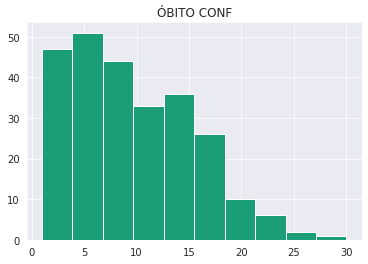

In [72]:
obitos_cwb.hist();

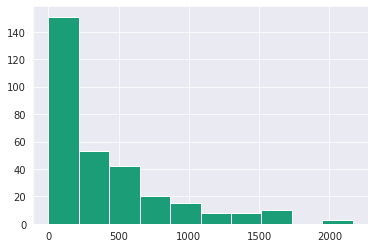

In [73]:
casos_confirmados['CONFIRMADO'].hist();

Mas por que fazemos o teste de estacionariedade?

Para que possamos fazer previsões em séries temporais, precisaremos garantir que elas sejam estacionárias.Caso contrário, será necessário levarmos em consideração características da série temporal que a tornam não-estacionária, no momento de previsão.



Vamos transformar a série em estacionária para podermos efetuar a análise de correlação. Para isso, vamos usar o diff. Para sabermos quantos diffs serão necessários para transformarmos a série em estacionária, vamos usar o teste **Kwiatkowski-Phillips-Schmidt**

In [74]:
from pmdarima.arima import ADFTest, ndiffs

In [75]:
ndiffs(casos_confirmados['CONFIRMADO'], alpha=.05, test='kpss', max_d=2)

1

In [76]:
ndiffs(obitos_cwb['ÓBITO CONF'], alpha=.05, test='kpss', max_d=2)

1

In [77]:
casos_confirmados['AUMENTO'] = casos_confirmados['CONFIRMADO'].diff() #este passo já deve transformar nossa série em estacionária
casos_confirmados['ACELERACAO'] = casos_confirmados['AUMENTO'].diff()

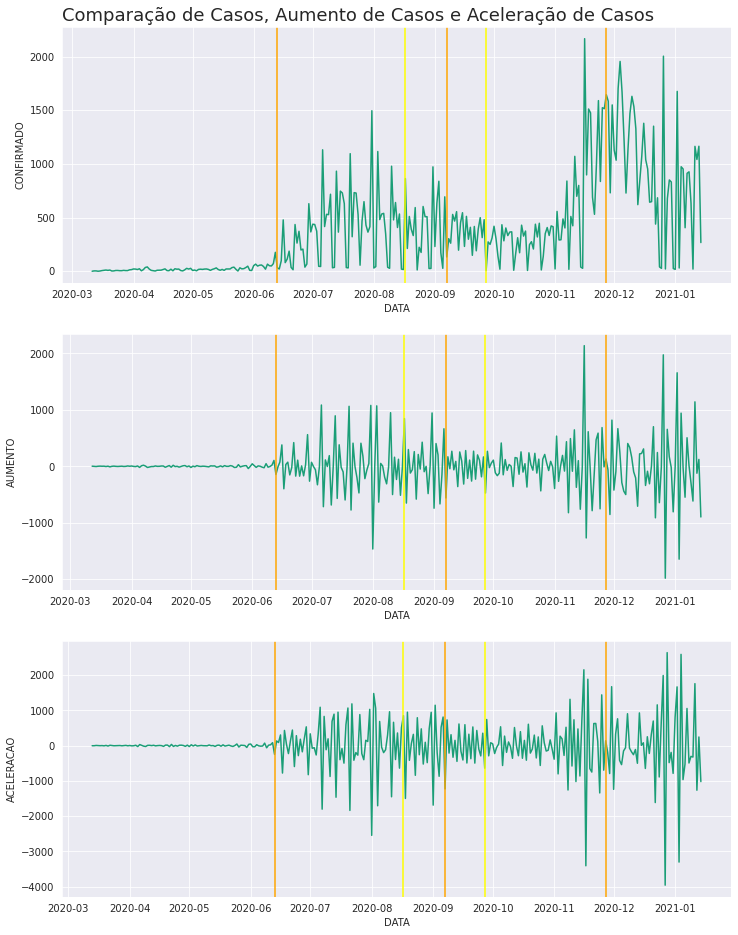

In [78]:
plot_comparacao(casos_confirmados.index, 'CONFIRMADO', 'AUMENTO','ACELERACAO', casos_confirmados,
                "Comparação de Casos, Aumento de Casos e Aceleração de Casos")

Vamos agora confirmar se efetivamente nosso aumento é uma série estacionária, lembrando que nossa hipótese nula é que a série não é estacionária

In [79]:
stat, p_valor, lags, nobs, critical_values, icbest = adfuller(casos_confirmados['AUMENTO'][1:].values)

In [80]:
#conferindo se a série com um diff é estacionária
testa_p_value(p_valor)

Podemos rejeitar a hipótese nula
o p_value é de 0.0312683013370363


In [81]:
#usando outro teste para verificar a hipótese. 
#Vamos usar a função should_diff, que nos diz que precisamos ajustar a estacionariedade da série:
#should_diff(x)	Test whether the time series is stationary or needs differencing.
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(casos_confirmados['AUMENTO'][1:])

(0.01, False)

Vamos agora aplicar a mesma lógica para o dataset de óbitos

In [82]:
obitos_cwb['AUMENTO'] = obitos_cwb['ÓBITO CONF'].diff() #este passo já deve transformar nossa série em estacionária
obitos_cwb['ACELERACAO'] = obitos_cwb['AUMENTO'].diff()

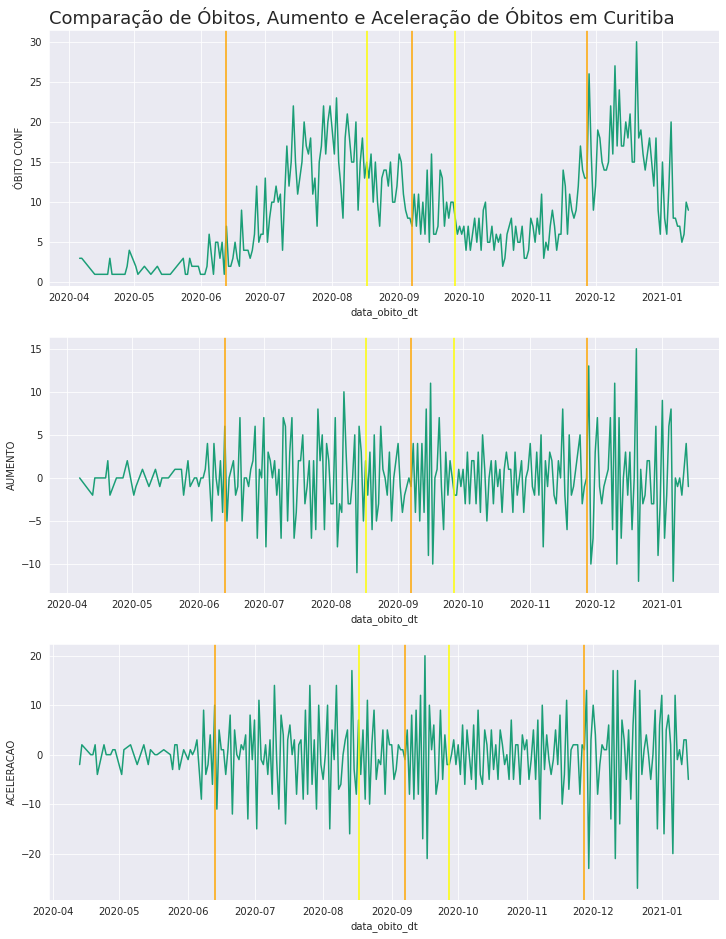

In [83]:
plot_comparacao(obitos_cwb.index, 'ÓBITO CONF', 'AUMENTO','ACELERACAO', obitos_cwb,
                "Comparação de Óbitos, Aumento e Aceleração de Óbitos em Curitiba")

In [84]:
#usando outro teste para verificar a hipótese. 
#Vamos usar a função should_diff, que nos diz que precisamos ajustar a estacionariedade da série:
#should_diff(x)	Test whether the time series is stationary or needs differencing.
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(obitos_cwb['AUMENTO'][1:])

(0.01, False)

#### **Verificando a Autocorrelação dos dados**

Agora que transformamos as duas séries em estacionárias, vamos verificar sua autocorrelação, para determinar nosso modelo de previsões. Para isso vamos verificar a Autocorrelação total e parcial, uma vez que a ACF  define o parâmetro p do modelo ARMA, e a PACF o parâmetro q do modelo.

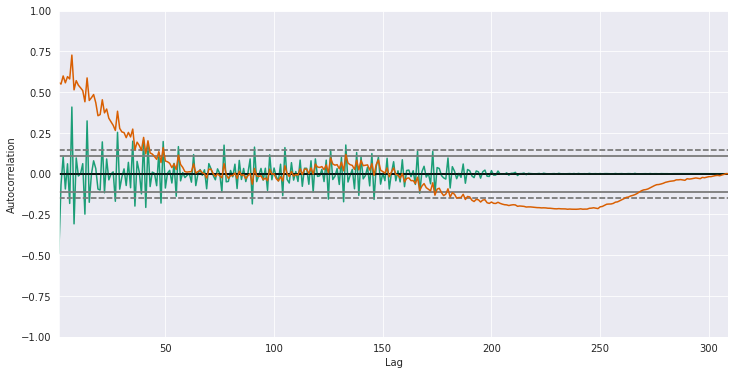

In [85]:
plt.figure(figsize=(12,6))
#autocorrelação da série estacionária (verde)
autocorrelation_plot(casos_confirmados['AUMENTO'][1:])
#autocorrelação da série não estacionária( laranja)
autocorrelation_plot(casos_confirmados['CONFIRMADO'][1:]);

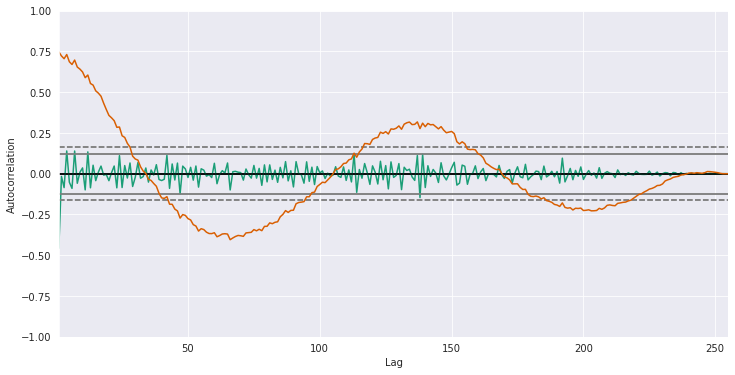

In [86]:
plt.figure(figsize=(12,6))
#autocorrelação da série estacionária(verde)
autocorrelation_plot(obitos_cwb['AUMENTO'][1:])
#autocorrelação da série não estacionária( laranja)
autocorrelation_plot(obitos_cwb['ÓBITO CONF'][1:]);

In [87]:
#importando os plots de autocorrelação e autocorrelação parcial
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

##### **ACF E PACF das séries estacionárias**

Vamos primeiro gerar os gráficos de Autocorrelação parcial e total para nossos **casos confirmados**, usando a série de Aumento, ou seja, estacionária

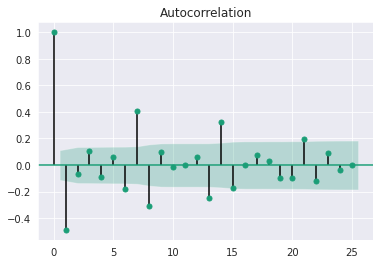

In [88]:
plot_acf(casos_confirmados['AUMENTO'][1:]);

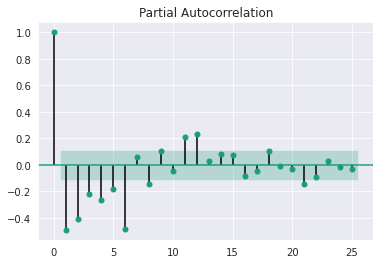

In [89]:
plot_pacf(casos_confirmados['AUMENTO'][1:]);

Para nossa previsão de aumento casos confirmados, usaríamos o p=3 e o q=6, seguindo os gráficos de autocorrelação acima. Mas antes vamos fazer a mesma coisa para o dataset de **óbitos**

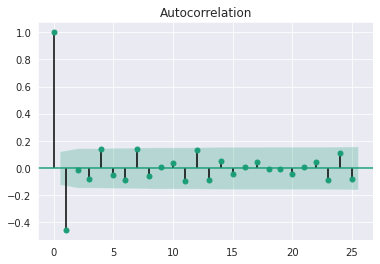

In [90]:
plot_acf(obitos_cwb['AUMENTO'][1:]);

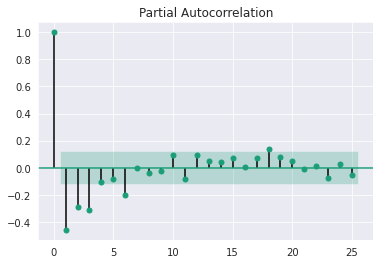

In [91]:
plot_pacf(obitos_cwb['AUMENTO'][1:]);

Para óbitos usaríamos p=1 e q=3 para prever o aumento de casos

##### **ACF E PACF das séries não estacionárias**

Vamos primeiro gerar os gráficos de Autocorrelação parcial e total para nossos **casos confirmados**, usando a série de dados original, ou seja, não estacionária

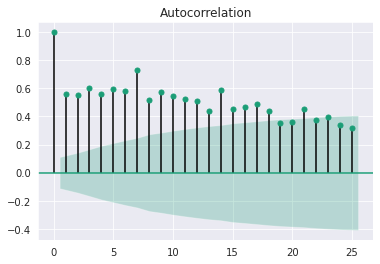

In [92]:
p=18
plot_acf(casos_confirmados['CONFIRMADO']);

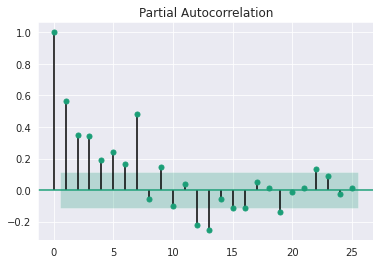

In [93]:
q=7
plot_pacf(casos_confirmados['CONFIRMADO']);

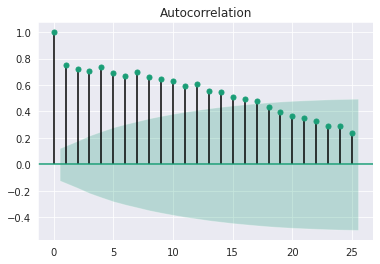

In [94]:
p_o = 16
plot_acf(obitos_cwb['ÓBITO CONF']);

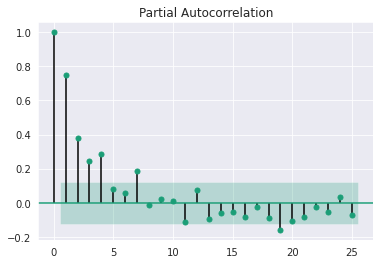

In [95]:
q_o = 5
plot_pacf(obitos_cwb['ÓBITO CONF']);

### **TESTANDO PREVISÕES**

#### Separando os dados em treino e teste

In [96]:
casos_confirmados['ano'] = casos_confirmados.index.year
obitos_cwb['ano'] = obitos_cwb.index.year


In [97]:
confirmados_treino = casos_confirmados.loc[casos_confirmados['ano'] == 2020]
confirmados_teste = casos_confirmados.loc[casos_confirmados['ano'] == 2021]

In [98]:
obitos_treino = obitos_cwb.loc[obitos_cwb['ano'] == 2020]
obitos_teste = obitos_cwb.loc[obitos_cwb['ano'] == 2021]

#### Aplicando o ARIMA

Vamos usar o p e o q conforme as planilhas das séries não estacionárias

In [307]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
arima_casos = ARIMA(confirmados_treino['CONFIRMADO'].values.astype('float32'), order=[3,1,7])
arima_casos_treinado = arima_casos.fit()
previsao_casos = arima_casos_treinado.forecast(steps=14)[0];

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.m

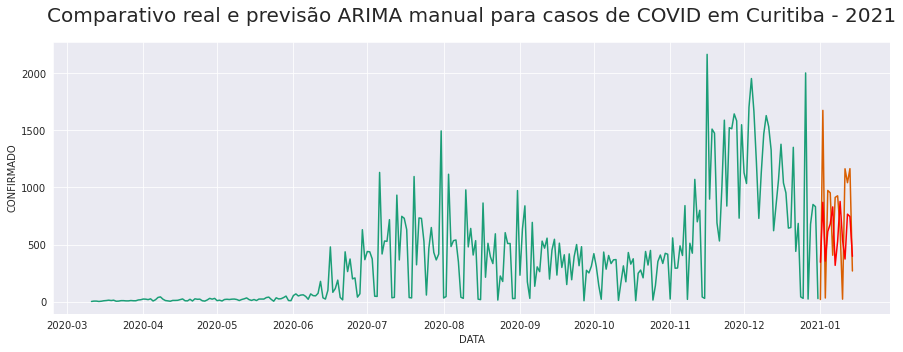

In [308]:
plt.figure(figsize=(15,5))
sns.lineplot(x=confirmados_treino.index, y='CONFIRMADO', data=confirmados_treino)
sns.lineplot(x=confirmados_teste.index, y='CONFIRMADO', data=confirmados_teste)
sns.lineplot(x=confirmados_teste.index, y=previsao_casos, color='r')
plt.title('Comparativo real e previsão ARIMA manual para casos de COVID em Curitiba - 2021', fontsize=20, pad=20);

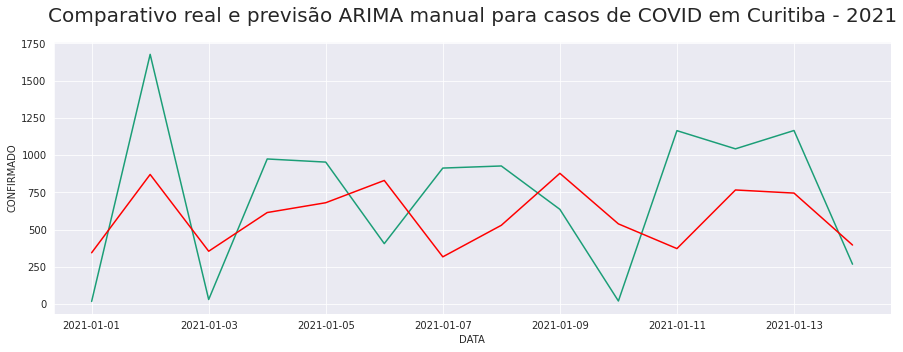

In [309]:
plt.figure(figsize=(15,5))
sns.lineplot(x=confirmados_teste.index, y='CONFIRMADO', data=confirmados_teste)
sns.lineplot(x=confirmados_teste.index, y=previsao_casos, color='r')
plt.title('Comparativo real e previsão ARIMA manual para casos de COVID em Curitiba - 2021', fontsize=20, pad=20);

In [305]:
arima_obitos = ARIMA(obitos_treino['ÓBITO CONF'].values.astype('float32'), order=[1,1,7])
arima_obitos_treinado = arima_obitos.fit()
previsao_obitos = arima_obitos_treinado.forecast(steps=13)[0]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.m

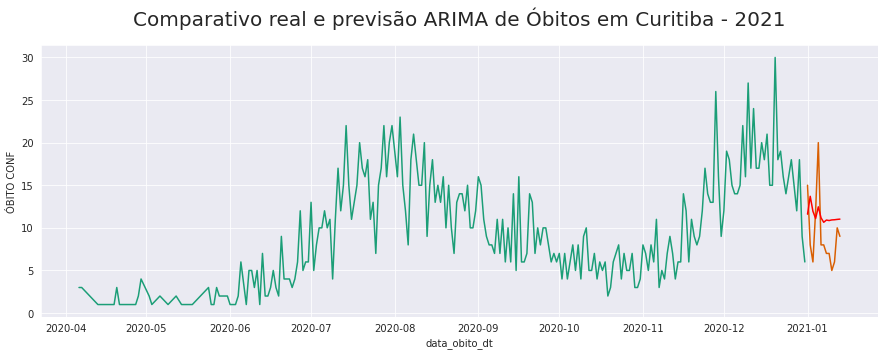

In [306]:
plt.figure(figsize=(15,5))
sns.lineplot(x=obitos_treino.index, y='ÓBITO CONF', data=obitos_treino)
sns.lineplot(x=obitos_teste.index, y='ÓBITO CONF', data=obitos_teste)
sns.lineplot(x=obitos_teste.index, y=previsao_obitos, color='r')
plt.title('Comparativo real e previsão ARIMA de Óbitos em Curitiba - 2021', fontsize=20, pad=20);

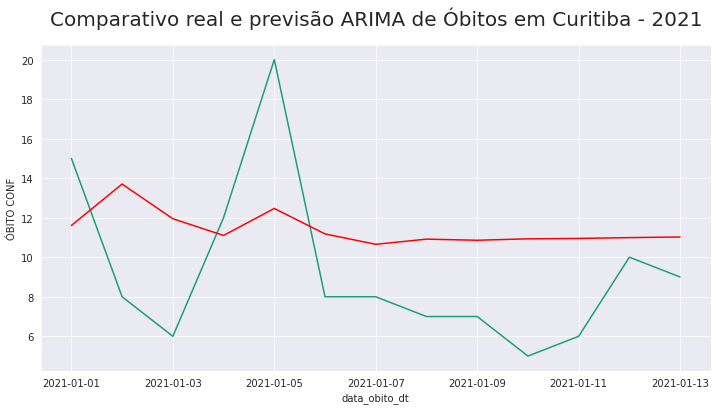

In [311]:
plt.figure(figsize=(12,6))
sns.lineplot(x=obitos_teste.index, y='ÓBITO CONF', data=obitos_teste)
sns.lineplot(x=obitos_teste.index, y=previsao_obitos, color='r')
plt.title('Comparativo real e previsão ARIMA de Óbitos em Curitiba - 2021', fontsize=20, pad=20);

Vemos pelo gráfico que ele até segue a tendência, mas não faz previsões muito acuradas. Vamos testar agora usando o Auto-Arima

#### Aplicando o AutoArima

O Auto-Arima possui um parâmetro para informar se se trata ou não de uma série estacionária.

In [321]:
#incluindo sazonalidade no modelo (parâmetro "m")
modelo_autoarima = auto_arima(confirmados_treino['CONFIRMADO'].values,error_action='ignore',
                              seasonal=None, max_p=20, max_q=20,)

/usr/local/lib/python3.6/dist-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (7) set for non-seasonal fit. Setting to 0



In [323]:
y_pred_casos = modelo_autoarima.predict(14)

In [322]:
modelo_autoarima_obitos = auto_arima(obitos_treino['ÓBITO CONF'].values,error_action='ignore',
                              seasonal=None,max_p=20, max_q=20)

In [324]:
y_pred_obitos = modelo_autoarima_obitos.predict(14)

Vamos agora verificar como as previsões se saíram graficamente

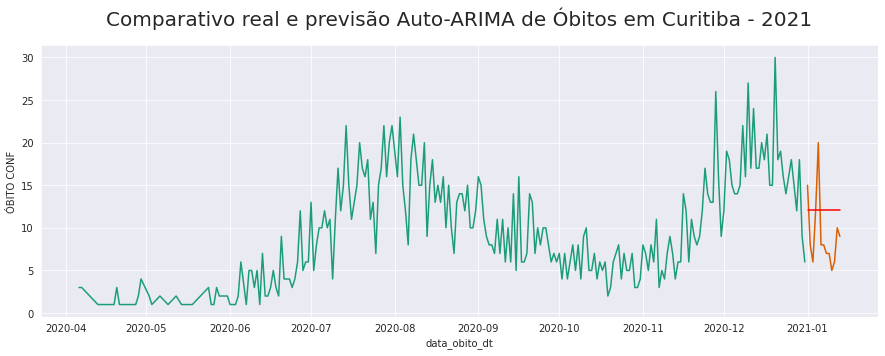

In [325]:
plt.figure(figsize=(15,5))
sns.lineplot(x=obitos_treino.index, y='ÓBITO CONF', data=obitos_treino)
sns.lineplot(x=obitos_teste.index, y='ÓBITO CONF', data=obitos_teste)
sns.lineplot(x=obitos_teste.index, y=y_pred_obitos[1:], color='r')
plt.title('Comparativo real e previsão Auto-ARIMA de Óbitos em Curitiba - 2021', fontsize=20, pad=20);

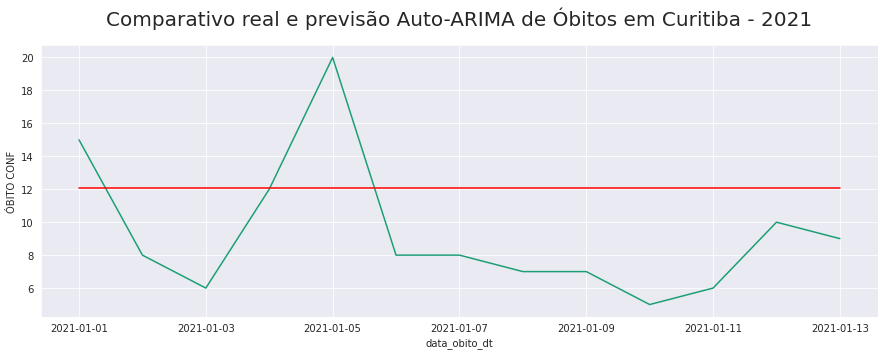

In [326]:
plt.figure(figsize=(15,5))
sns.lineplot(x=obitos_teste.index, y='ÓBITO CONF', data=obitos_teste)
sns.lineplot(x=obitos_teste.index, y=y_pred_obitos[1:], color='r')
plt.title('Comparativo real e previsão Auto-ARIMA de Óbitos em Curitiba - 2021', fontsize=20, pad=20);

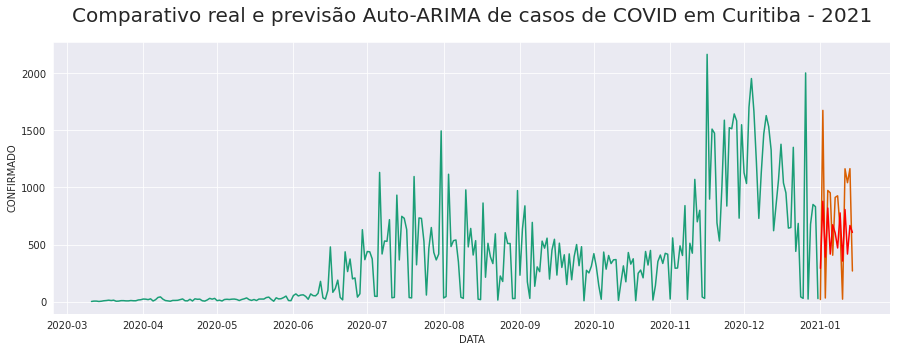

In [327]:
plt.figure(figsize=(15,5))
sns.lineplot(x=confirmados_treino.index, y='CONFIRMADO', data=confirmados_treino)
sns.lineplot(x=confirmados_teste.index, y='CONFIRMADO', data=confirmados_teste)
sns.lineplot(x=confirmados_teste.index, y=y_pred_casos, color='r')
plt.title('Comparativo real e previsão Auto-ARIMA de casos de COVID em Curitiba - 2021', fontsize=20, pad=20);

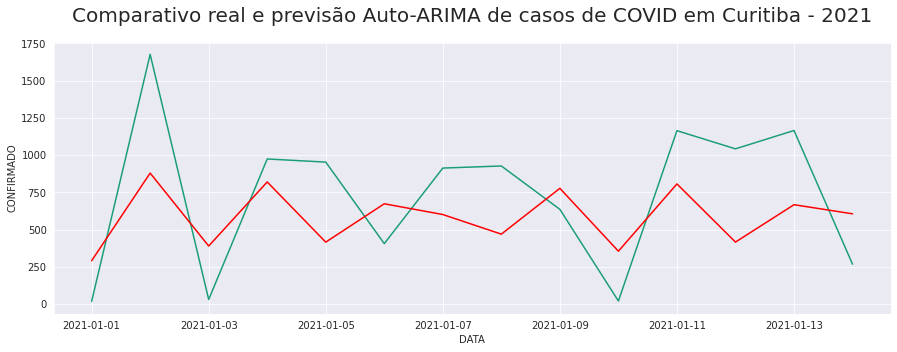

In [328]:
plt.figure(figsize=(15,5))
sns.lineplot(x=confirmados_teste.index, y='CONFIRMADO', data=confirmados_teste)
sns.lineplot(x=confirmados_teste.index, y=y_pred_casos, color='r')
plt.title('Comparativo real e previsão Auto-ARIMA de casos de COVID em Curitiba - 2021', fontsize=20, pad=20);

#### Plotando o diagnóstico dos modelos automáticos

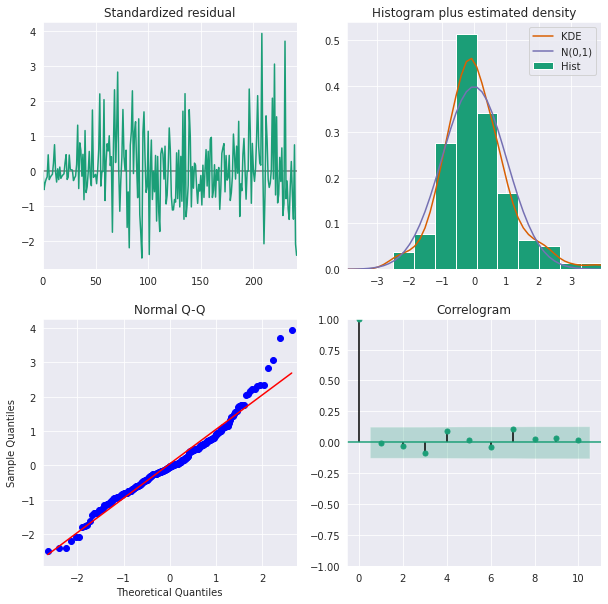

In [329]:
modelo_autoarima_obitos.plot_diagnostics(figsize=(10,10));

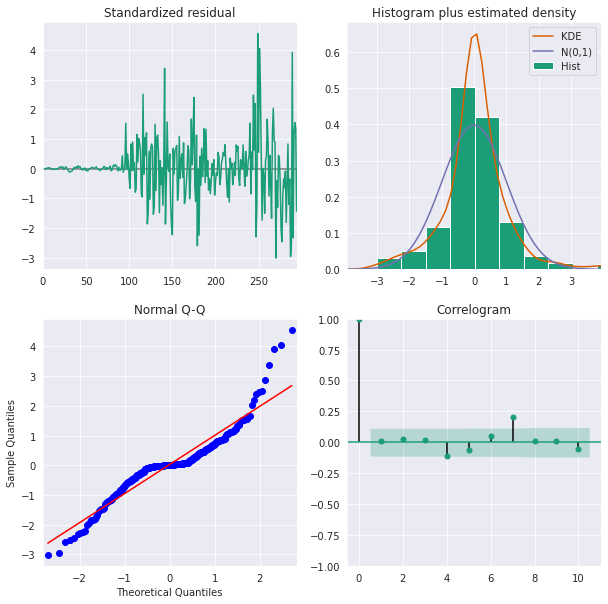

In [330]:
modelo_autoarima.plot_diagnostics(figsize=(10,10));

Verificando a acurácia dos modelos ARIMA e Auto_Arima

In [331]:
from sklearn.metrics import r2_score

In [332]:
r2_score(confirmados_teste['CONFIRMADO'], previsao_casos)

0.11787493472265109

In [333]:
r2_score(confirmados_teste['CONFIRMADO'], y_pred_casos)

0.24748825641333339

In [334]:
r2_score(obitos_teste['ÓBITO CONF'], previsao_obitos)

-0.18184339424107154

In [335]:
r2_score(obitos_teste['ÓBITO CONF'], y_pred_obitos[1:])

-0.46389037463154814

Nossos modelos não performaram muito bem, sendo que a previsão pela média teria mais acurácia do que as previsões dos modelos em 3 dos 4 casos, e no caso positivo, a melhora é marginal (0,10 de possível 1). Vamos fazer um teste usando o Prophet do Facebook

### **USANDO O PROPHET**

In [199]:
#usando o Prophet
from fbprophet import Prophet

#### Criando novos datasets de treino e teste para que eles casem com a funcionalidade do Prophet. 

A lib exige que a coluna de data se chame "ds" e a coluna prevista se chame "y". Vamos ainda incluir ao modelo as datas das mudanças de bandeira para tentar ajustar o modelo

In [366]:
colunas_casos={'DATA':'ds', 'CONFIRMADO':'y'}
colunas_obitos = {'data_obito_dt':'ds','ÓBITO CONF':'y'}
casos_prophet_treino = confirmados_treino[['CONFIRMADO']].reset_index().rename(colunas_casos, axis=1)
casos_prophet_teste = confirmados_teste[['CONFIRMADO']].reset_index().rename(colunas_casos, axis=1)


In [367]:
obitos_prophet_treino = obitos_treino[['ÓBITO CONF']].reset_index().rename(colunas_obitos, axis=1)
obitos_prophet_teste = obitos_teste[['ÓBITO CONF']].reset_index().rename(colunas_obitos, axis=1)

In [368]:
#instanciando o modelo
modelo_prophet = Prophet(seasonality_mode='multiplicative',daily_seasonality=True, 
                         changepoints=['2020-06-13','2020-08-17','2020-09-07', '2020-09-27', '2020-11-27'])


In [369]:
#incluindo as datas das bandeiras como changepoints para ver se melhora a previsão
modelo_p_obitos = Prophet(seasonality_mode='multiplicative', daily_seasonality=True,
                          changepoints=['2020-06-13','2020-08-17','2020-09-07', '2020-09-27', '2020-11-27'])

In [370]:
#treinando o modelo
modelo_prophet_casos = modelo_prophet.fit(casos_prophet_treino)
modelo_prophet_obitos = modelo_p_obitos.fit(obitos_prophet_treino)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [371]:
#criando a previsão do modelo
#para o prophet há mais passos para fazer a previsão. 1) Criar o 'FUTURO"
futuro_casos = modelo_prophet_casos.make_future_dataframe(periods=14,freq='D')
futuro_casos

,ds
0,2020-03-11
1,2020-03-12
2,2020-03-13
3,2020-03-14
4,2020-03-15
...,...
305,2021-01-10
306,2021-01-11
307,2021-01-12
308,2021-01-13


In [372]:
futuro_obitos = modelo_prophet_obitos.make_future_dataframe(periods=13,freq='D')
futuro_obitos

,ds
0,2020-04-06
1,2020-04-07
2,2020-04-13
3,2020-04-14
4,2020-04-18
...,...
251,2021-01-09
252,2021-01-10
253,2021-01-11
254,2021-01-12


In [373]:
#fazendo a previsão - recebe o futuro criado acima como parâmetro
resultado_casos = modelo_prophet_casos.predict(futuro_casos)
resultado_obitos = modelo_prophet_obitos.predict(futuro_obitos)

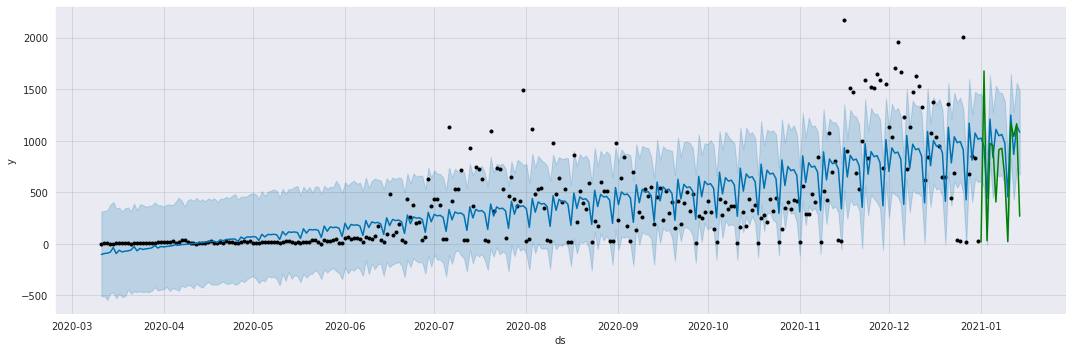

In [377]:
#plotando o resultado
modelo_prophet_casos.plot(resultado_casos, figsize=(15,5))
sns.lineplot(x=confirmados_teste.index, y=confirmados_teste['CONFIRMADO'], color='g');

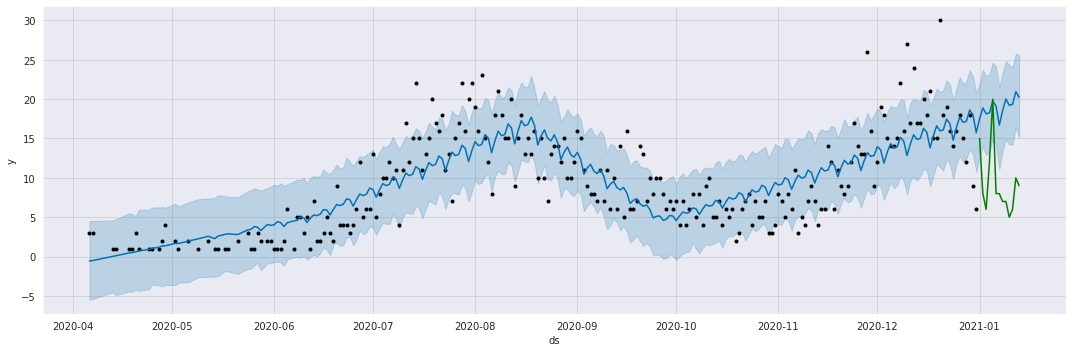

In [378]:
#plotando o resultado
modelo_prophet_obitos.plot(resultado_obitos, figsize=(15,5))
sns.lineplot(x=obitos_teste.index, y=obitos_teste['ÓBITO CONF'], color='g');

Vemos que o modelo não se ajustou muito bem ao Prophet. No entanto, a inclusão das datas de mudança de acordo com as mudanças de bandeira melhorou o gráfico de óbitos significativamente.

### Testando a Suavização exponencial de HoltWinters

In [130]:
#importando o objeto
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [218]:
#calculando as semanas epidemiológicas
dados['semanaEpi'].nunique()

43

In [292]:
#função ExponencialSmoothing do pacote statsmodels
modelo_ajustado = ExponentialSmoothing(confirmados_treino['CONFIRMADO'].values, trend='multiplicative', 
                     seasonal='multiplicative',seasonal_periods=14).fit() #informa os dados, tendência, sazonalidade e períodos

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [293]:
#fazendo previsões
confirmados_teste.shape[0], casos_confirmados.shape[0]

(14, 310)

In [294]:
modelo_previsto = modelo_ajustado.predict(start=(310-14), end = 309)

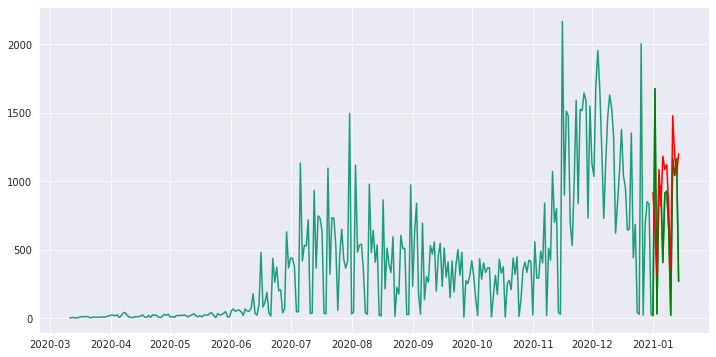

In [295]:
#plotando os dados
plt.figure(figsize=(12,6))
plt.plot(casos_confirmados['CONFIRMADO'])
plt.plot(confirmados_teste['CONFIRMADO'], 'g') #linha verde
plt.plot(confirmados_teste.index, modelo_previsto, 'r')#linha vermelha
plt.show()

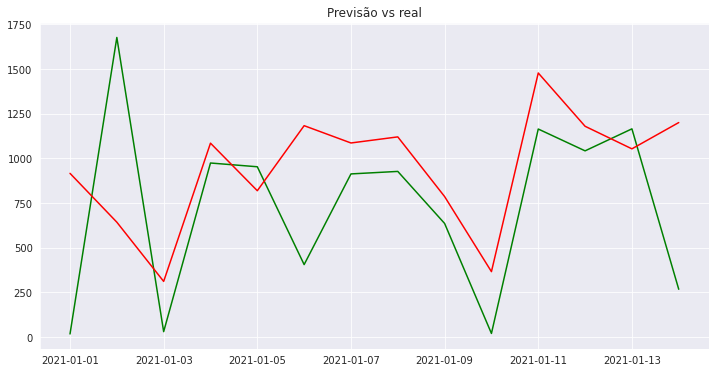

In [296]:
#plotando os dados
plt.figure(figsize=(12,6))
plt.plot(confirmados_teste['CONFIRMADO'], 'g') #linha verde
plt.plot(confirmados_teste.index, modelo_previsto, 'r')#linha vermelha
plt.title('Previsão vs real')
plt.show()

In [297]:
r2_score(confirmados_teste['CONFIRMADO'],modelo_previsto)

-0.12352224720163374

In [228]:
#função ExponencialSmoothing do pacote statsmodels
modelo_ajustado_obitos = ExponentialSmoothing(obitos_treino['ÓBITO CONF'].values, trend='additive', 
                     seasonal='additive', seasonal_periods=41).fit() #informa os dados, tendência, sazonalidade e períodos

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



In [229]:
#fazendo previsões
obitos_teste.shape[0], obitos_cwb.shape[0]

(13, 256)

In [230]:
modelo_previsto_obitos = modelo_ajustado_obitos.predict(start=(256-13), end = 255)

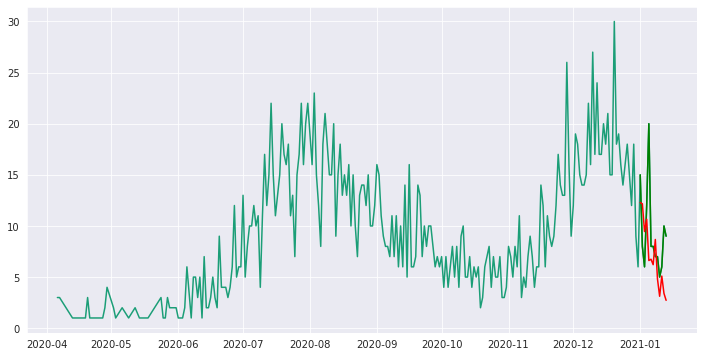

In [231]:
#plotando os dados
plt.figure(figsize=(12,6))
plt.plot(obitos_cwb['ÓBITO CONF'])
plt.plot(obitos_teste['ÓBITO CONF'], 'g') #linha verde
plt.plot(obitos_teste.index, modelo_previsto_obitos, 'r')#pontos vermelhos
plt.show()

## **CONCLUSÃO**

Muitos fatores importam quando falamos de casos como a Pandemia. Nossas projeções não se sairam muito bem com os dados reais, o que nos leva a crer que precisamos ajustar melhor nossos dados, mas também significa que fazer previsão dependendo do comportamento humano e de ações governamentais não é nada fácil.

Nossos planos originais eram:

* Analisar as bases uma contra a outra,
* Conferir as diferenças de SRAG e COVID,
* Fazer um perfil dos infectados em Curitiba,
* Fazer um perfil dos sintomas mais comuns na base de SRAG,
* Verificar se a base municipal está de acordo com a base federal
* Comparar as bases de Curitiba e do Paraná
* Fazer a série temporal da evolução de casos de covid,
* Testar a previsão com janeiro de 2021 e fazer a projeção até o meu aniversário (16/06).
* Verificar se a projeção ocuparia todos os leitos de cwb em algum momento * como ocorreu em Manaus.
* Usar a média móvel de 14 dias pois é o tempo de incubação(?),
* Fazer uma série temporal dos decretos de contenção do vírus em Curitiba * para ver se tem reflexo em queda de casos.
* Comparar infecções SRAG com os hospitais

Com o desenvolver do trabalho, notamos que a base federal contém valores em desacordo com os dados municipais, que possuem uma curva mais suave, e identificou mais casos do que a base federal, motivo pelo qual escolhemos ficar com esta base.

Conseguimos fazer um perfil básico sobre os curitibanos diagnosticados com COVID, e conseguimos visualizar quão perigosa é a doença para os grupo de risco formado por idosos.

Descartamos as análises de SRAG como um todo, em virtude do tempo consumido na análise das séries temporais de casos confirmados e óbitos. Achamos que esta análise iria desviar demais do objetivo do trabalho, mas guardamos a ideia para uma nova análise num segundo momento. Não conseguimos trabalhar os dados de forma a prever o uso de leitos, portanto também descartamos essa ideia.

Nossas tentativas de previsão não se comportaram como o esperado, seja por falta de experiência ou mesmo por não se tratar de uma situação previsível, uma vez que vários fatores impactam a progressão da série, como a quantidade de pessoas em circulação, uso de máscara, decretos municipais, variante do vírus, comportamentos de risco, etc. Nossa melhor previsão (com um R2 de 0,24) foi o auto-arima dos casos confirmados, motivo pelo qual vou fechar este trabalho com uma previsão até junho usando esta previsão, apenas como exercício.




In [379]:
#incluindo sazonalidade no modelo (parâmetro "m")
modelo_autoarima_projecao = auto_arima(casos_confirmados['CONFIRMADO'].values,error_action='ignore',
                              seasonal=None, max_p=20, max_q=20,)

In [388]:
y_projecao = y_pred_casos = modelo_autoarima.predict(153)

In [391]:
datelist = pd.date_range(dt.datetime(2021,1,14), periods=153).tolist()

In [397]:
projecao = pd.DataFrame(index=datelist)
projecao['projecao'] = y_projecao

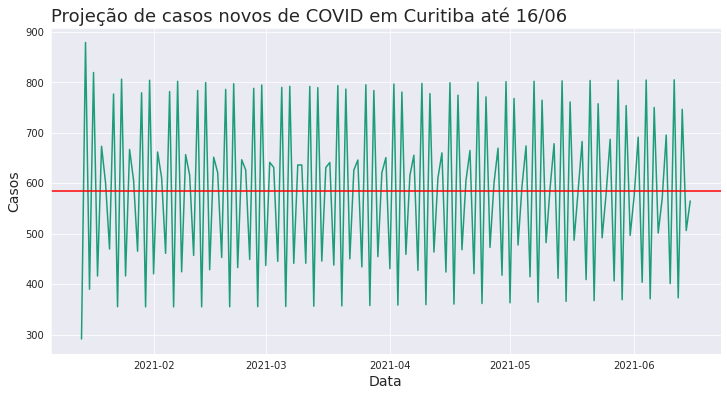

In [404]:
plotar('Projeção de casos novos de COVID em Curitiba até 16/06','Data', 'Casos', 
       projecao.index, 'projecao',projecao)
plt.axhline(y=projecao['projecao'].mean(), color='r');

Fontes:

Painel Covid Curitiba - https://mid.curitiba.pr.gov.br/conteudos/coronavirus/PAINEL_COVID_CTBA_27112020.pdf

Calendário Epidemiológico 2021 - http://portalsinan.saude.gov.br/calendario-epidemiologico

Dados Abertos Covid Curitiba - https://www.curitiba.pr.gov.br/dadosabertos/busca/?grupo=16

Observatório COVID = https://covid19br.github.io/

Banco de Dados da SRAG - https://opendatasus.saude.gov.br/dataset/bd-srag-2020

Painel Covid Governo - https://covid.saude.gov.br/

Dicionário de Dados SRAG -https://opendatasus.saude.gov.br/dataset/ae90fa8f-3e94-467e-a33f-94adbb66edf8/resource/8f571374-c555-4ec0-8e44-00b1e8b11c25/download/dicionario-de-dados-srag-hospitalizado-27.07.2020-final.pdf

Métricas de Séries Temporais - https://joydeep31415.medium.com/common-metrics-for-time-series-analysis-f3ca4b29fe42

Vigilância Epidemiológica de Curitiba - http://www.saude.curitiba.pr.gov.br/vigilancia/epidemiologica/vigilancia-de-a-a-z/12-vigilancia/1290-coronavirus.html


Decretos contenção Covid Cwb - https://www.curitiba.pr.gov.br/noticias/decretos-amparam-medidas-de-combate-ao-coronavirus/55390

Plano de Contingência CWB = http://www.saude.curitiba.pr.gov.br/vigilancia/epidemiologica/vigilancia-de-a-a-z/12-vigilancia/1474-plano-contigencia.html e http://www.saude.curitiba.pr.gov.br/images/Plano_de_Contingencia_N%20Coronav%C3%ADrus%20revisado%2028122020.pdf

Plano de Vacinação - http://www.saude.curitiba.pr.gov.br/images/Plano%20de%20Vacina%C3%A7%C3%A3o%20Curitiba%20-%2020210114_5.pdf

Linha do Tempo Curitiba = https://www.observatoriodasmetropoles.net.br/wp-content/uploads/2020/07/Quadro-1-Linha-do-Tempo-em-Curitiba.jpg

Última atualização - https://g1.globo.com/pr/parana/noticia/2021/01/22/coronavirus-prefeitura-prorroga-bandeira-laranja-em-curitiba-ate-27-de-janeiro-e-libera-praticas-esportivas-coletivas.ghtml

retrospectiva 2020 COVID -https://cbncuritiba.com/retrospectiva-2020-o-ano-alterado-pela-pandemia-de-covid-19/

evolução tardia da COVID - https://www.observatoriodasmetropoles.net.br/a-evolucao-tardia-da-covid-19-na-regiao-metropolitana-de-curitiba/





